<a href="https://colab.research.google.com/github/SeongminCC/agriculture-production/blob/main/modeling_Randomforest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# validation AUC, MSE, RMSE, Accuracy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

/content/drive/MyDrive/DNA/농넷_AIFactory
total 21
-rw------- 1 root root 6274 Sep 18 04:08  테스트1.csv
-rw------- 1 root root 4646 Sep 18 04:07  테스트3.csv
drwx------ 3 root root 4096 Sep  4 13:59  aT_data
-rw------- 1 root root  370 Sep  4 14:19  lstm.ipynb
drwx------ 2 root root 4096 Sep  8 10:54  tmp_checkpoint.h10
-rw------- 1 root root  118 Sep 16 04:31 '과제 평가지표 종류.txt'
MAE : 0.018811612295552286
0.0004988561105696602
0.022335086983704813

 **test데이터 도입**
MAE : 0.20701182023898948
0.07039483749562706
0.265320254589858


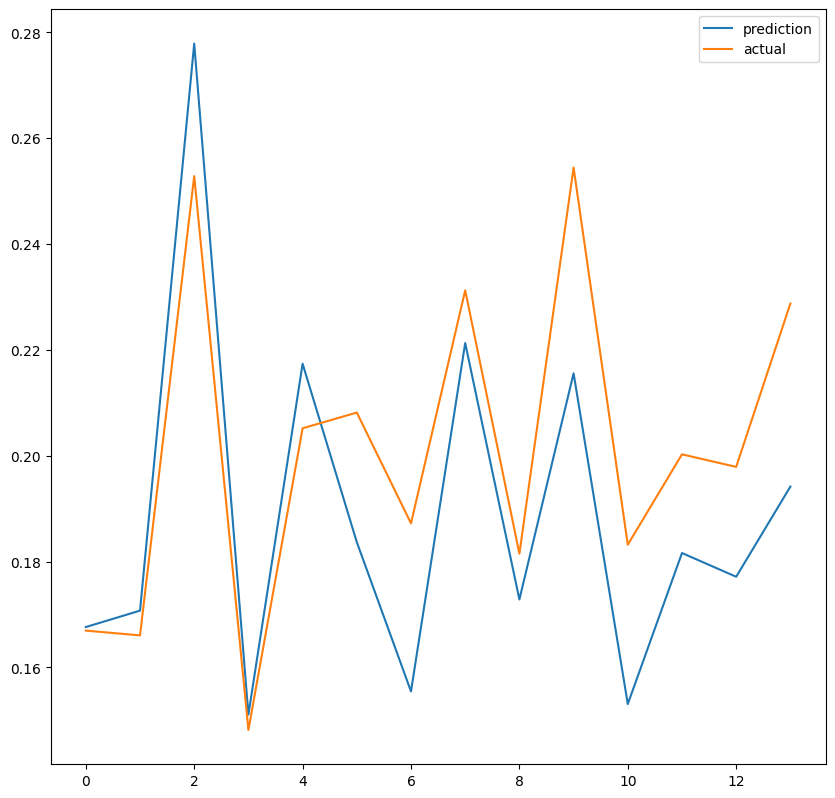

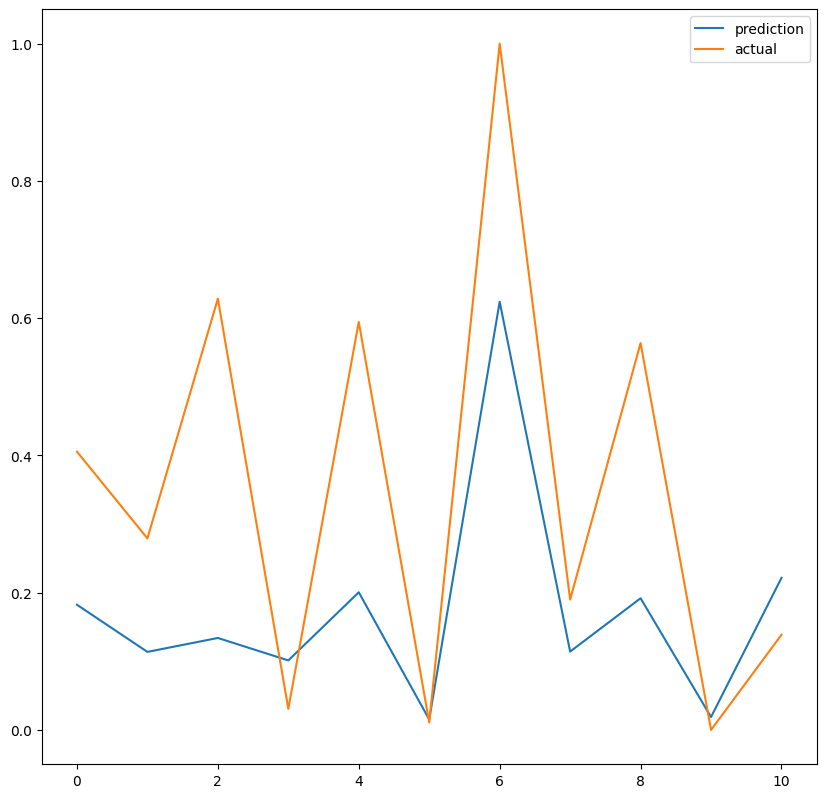

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings

import random
import os

import matplotlib.pylab as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score, auc

import os
import numpy as np


import math


# 경고 끄기
warnings.filterwarnings(action='ignore')

# 시드고정
random.seed(19970119)
np.random.seed(19970119)


%cd /content/drive/MyDrive/DNA/농넷_AIFactory
!ls -al


# train, test 경로 설정
tr_path = './aT_data/data/train'
ts_path = './aT_data/data/test'

# 품목 하나에 대하여 csv파일 불러오기
df1 = pd.read_csv(tr_path + '/train_0.csv')
df1_test = pd.read_csv(ts_path + '/set_0/test_0.csv')


# 훈련 데이터 fillna로 결측치 채우기
# df2 = df1.fillna(method='ffill') # 결측치 위치 기준 윗 값 가져오기 
# df2 = df1.fillna(method='bfill') # 결측치 위치 기준 아랫 값 가져오기

# 훈련 데이터 dropna로 결측치 제거하기
df2 = df1.dropna()
df2


# 테스트 데이터
# 단가(원)이 결측치면 행 제거
df2_test = df1_test.dropna(subset = ['단가(원)'])
df2_test['일자별_도매가격_최대(원)']
# 결측치 위치 기준 아랫 값 가져오기
df3_test = df2_test.fillna(method='bfill')
df3_test = df2_test.fillna(method='ffill')




# 날짜 재 배열(train)
date = pd.to_datetime(df1['datadate'], format='%Y%m%d')
df2['datadate'] = date 
# 날짜 재 배열(test)
date_test = pd.to_datetime(df3_test['datadate'], format='%Y%m%d')
df3_test['datadate'] = date_test



# dtype이 object인 columns 삭제(train)
df3 = df2.drop(['주산지_0_습도(%)', '주산지_2_습도(%)', '주산지_2_습도(%)', '주산지_2_습도(%)'], axis=1)
# dtype이 object인 columns 삭제(test)
df4_test = df3_test.drop(['주산지_0_습도(%)'], axis=1)




# Normalization(train)
scaler = MinMaxScaler()
scale_cols = ['단가(원)', '거래량', '거래대금(원)', '경매건수', '도매시장코드', '도매법인코드',
       '산지코드 ', '해당일자_전체평균가격(원)', '해당일자_전체거래물량(kg)', '하위가격 평균가(원)',
       '상위가격 평균가(원)', '하위가격 거래물량(kg)', '상위가격 거래물량(kg)', '일자별_도매가격_최대(원)',
       '일자별_도매가격_평균(원)', '일자별_도매가격_최소(원)', '일자별_소매가격_최대(원)', '일자별_소매가격_평균(원)',
       '일자별_소매가격_최소(원)', '수출중량(kg)', '수출금액(달러)', '수입중량(kg)', '수입금액(달러)',
       '무역수지(달러)', '주산지_0_초기온도(℃)', '주산지_0_최대온도(℃)', '주산지_0_최저온도(℃)',
       '주산지_0_평균온도(℃)', '주산지_0_강수량(ml)', '주산지_1_초기온도(℃)', '주산지_1_최대온도(℃)',
       '주산지_1_최저온도(℃)', '주산지_1_평균온도(℃)', '주산지_1_강수량(ml)', '주산지_1_습도(%)',
       '주산지_2_초기온도(℃)', '주산지_2_최대온도(℃)', '주산지_2_최저온도(℃)', '주산지_2_평균온도(℃)',
       '주산지_2_강수량(ml)','일자구분_중순', '일자구분_초순']
                
df_scaled = scaler.fit_transform(df3[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

# Normalization(test)
scaler_ts = MinMaxScaler()
scale_cols_ts = ['단가(원)', '거래량', '거래대금(원)', '경매건수', '도매시장코드', '도매법인코드',
       '산지코드 ', '해당일자_전체평균가격(원)', '해당일자_전체거래물량(kg)', '하위가격 평균가(원)',
       '상위가격 평균가(원)', '하위가격 거래물량(kg)', '상위가격 거래물량(kg)', '일자별_도매가격_최대(원)',
       '일자별_도매가격_평균(원)', '일자별_도매가격_최소(원)', '일자별_소매가격_최대(원)', '일자별_소매가격_평균(원)',
       '일자별_소매가격_최소(원)', '수출중량(kg)', '수출금액(달러)', '수입중량(kg)', '수입금액(달러)',
       '무역수지(달러)', '주산지_0_초기온도(℃)', '주산지_0_최대온도(℃)', '주산지_0_최저온도(℃)',
       '주산지_0_평균온도(℃)', '주산지_0_강수량(ml)', '주산지_1_초기온도(℃)', '주산지_1_최대온도(℃)',
       '주산지_1_최저온도(℃)', '주산지_1_평균온도(℃)', '주산지_1_강수량(ml)', '주산지_1_습도(%)',
       '주산지_2_초기온도(℃)', '주산지_2_최대온도(℃)', '주산지_2_최저온도(℃)', '주산지_2_평균온도(℃)',
       '주산지_2_강수량(ml)','일자구분_중순', '일자구분_초순']
                
# ['일자구분_하순', '월구분_10월', '월구분_11월', '월구분_12월', '월구분_2월', '월구분_3월', '월구분_4월', '월구분_5월', '월구분_6월', '월구분_7월', '월구분_8월', '월구분_9월'] not in index"  , '주산지_2_습도(%)'
df_scaled_ts = scaler_ts.fit_transform(df4_test[scale_cols_ts])

df_scaled_ts = pd.DataFrame(df_scaled_ts)
df_scaled_ts.columns = scale_cols_ts





# 랜덤 포레스트
######################################################################################################################
clf = RandomForestRegressor()


# 데이터 나누기
test_size = 14
X_train = df_scaled.drop(columns = '해당일자_전체평균가격(원)').iloc[:-test_size]
y_train = df_scaled['해당일자_전체평균가격(원)'].iloc[:-test_size]

X_val = df_scaled.drop(columns = '해당일자_전체평균가격(원)').iloc[-test_size:]
y_val = df_scaled['해당일자_전체평균가격(원)'].iloc[-test_size:]

# 학습
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)


# 평가지표
from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(y_val, y_pred)
MSE = mean_squared_error(y_val, y_pred)
RMSE = math.sqrt(mean_squared_error(y_val, y_pred))

print(f"MAE : {MAE}")
print(MSE)  
print(RMSE)





##############################################################################################################################
# 시각화
y_val.index = range(14)

fig = plt.figure(figsize = (10, 10), dpi = 100)
ax = fig.subplots()

ax.plot(y_pred, label = 'prediction')
ax.plot(y_val, label = 'actual')
ax.legend()






####################################################################################################################








clf = RandomForestRegressor()


# 데이터 나누기
X_train_ = df_scaled.drop(columns = '해당일자_전체평균가격(원)')
y_train_ = df_scaled['해당일자_전체평균가격(원)']

X_test = df_scaled_ts.drop(columns = '해당일자_전체평균가격(원)')
y_test = df_scaled_ts['해당일자_전체평균가격(원)']

# 학습
clf.fit(X_train_, y_train_)


### 결측치가 남아있는 부분이 있어 채워줌
X_test = X_test.fillna(method='bfill')
X_test = X_test.fillna(method='ffill')
X_test.to_csv("테스트1.csv", mode='w')
##
y_pred_ = clf.predict(X_test)


# 평가지표
from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(y_test, y_pred_)
MSE = mean_squared_error(y_test, y_pred_)
RMSE = math.sqrt(mean_squared_error(y_test, y_pred_))

print('\n **test데이터 도입**')
print(f"MAE : {MAE}")
print(MSE)  
print(RMSE)





##############################################################################################################################
# 시각화
y_test.index = range(11)

fig = plt.figure(figsize = (10, 10), dpi = 100)
ax1 = fig.subplots()

ax1.plot(y_pred_, label = 'prediction')
ax1.plot(y_test, label = 'actual')
ax1.legend()

In [ ]:
np.where(np.isnan(X_test))

(array([10, 10]), array([ 8, 10]))

In [ ]:
X_test = X_test.fillna(method='bfill')
X_test = X_test.fillna(method='ffill')
X_test.to_csv("테스트1.csv", mode='w')

In [ ]:
df10_test = df2_test.fillna(method='bfill')
df10_test = df2_test.fillna(method='ffill')
df10_test.to_csv("테스트3.csv", mode='w')